Simple simulation
==

A notebook for testing `mushi`'s ability to invert data simulated under the forward model

In [1]:
%matplotlib inline 
import mushi
import histories
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from scipy.special import expit
import composition as cmp
import stdpopsim

In [2]:
# plt.style.use('dark_background')

### Time grid

In [3]:
change_points = np.logspace(0, np.log10(100000), 100)
t = np.concatenate((np.array([0]), change_points))

### Define true demographic history

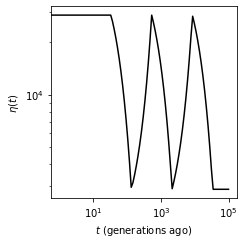

In [4]:
species = stdpopsim.get_species("HomSap")
model = species.get_demographic_model("Zigzag_1S14")
ddb = model.get_demography_debugger()
eta_true = histories.eta(change_points,
                       1 / ddb.coalescence_rate_trajectory(steps=t,
                                                           num_samples=[2],
                                                           double_step_validation=False)[0])

plt.figure(figsize=(3.5, 3.5))
eta_true.plot(c='k')
plt.show()

### Mutation rate history $\mu(t)$
A 96 dimensional history with a mixture of two latent signature: constant and pulse.

/home/kameron/local/anaconda3/envs/mushi/lib/python3.8/site-packages/jax/lib/xla_bridge.py:122: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


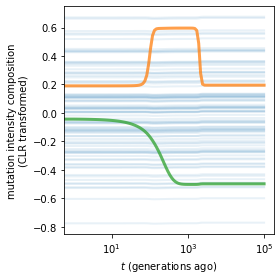

In [5]:
flat = np.ones_like(t)
pulse = expit(.1 * (t - 100)) - expit(.01 * (t - 2000))
ramp = expit(-.01 * (t - 100)) 
cols = 96
Z = np.zeros((len(t), cols))
mu0 = 1
np.random.seed(0)

Z[:, 0] = mu0 * (1 * flat + .5 * pulse)

Z[:, 1] = mu0 * (.5 * flat + .4 * ramp)

for col in range(2, cols):
    scale = np.random.lognormal(-.2, .3)
    pulse_weight = 5 if col == 0 else 0
    Z[:, col] = mu0 * scale * flat

mu_true = histories.mu(change_points, Z)

plt.figure(figsize=(4, 4))
mu_true.plot(range(2, cols), alpha=0.1, lw=2, c='C0', clr=True)
mu_true.plot((0,), alpha=0.75, lw=3, c='C1', clr=True)
mu_true.plot((1,), alpha=0.75, lw=3, c='C2', clr=True)
plt.show()

Estimate the total mutation rate using $t=0$

In [6]:
mu0 = mu_true.Z[0, :].sum()
print(mu0)

83.11894862750988


## Simulate a $k$-SFS
- We'll sample 200 haplotypes
- note that this simulation will have a slightly varying total mutation rate, due to the pulse

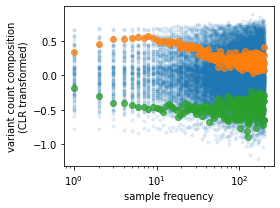

In [7]:
n = 200
ksfs = mushi.kSFS(n=n)
ksfs.simulate(eta_true, mu_true, seed=1)

plt.figure(figsize=(4, 3))
ksfs.plot(range(2, cols), clr=True, kwargs=dict(alpha=0.1, ls='', marker='.', c='C0'))
ksfs.plot((0,), clr=True, kwargs=dict(alpha=0.75, ls='', marker='o', c='C1'))
ksfs.plot((1,), clr=True, kwargs=dict(alpha=0.75, ls='', marker='o', c='C2'))
plt.show()

Number of segregating sites

In [8]:
ksfs.X.sum()

8245046

### TMRCA CDF

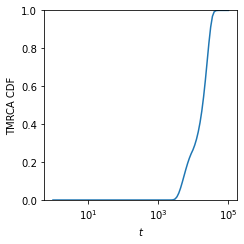

In [9]:
plt.figure(figsize=(3.5, 3.5))
plt.plot(change_points, ksfs.tmrca_cdf(eta_true))
plt.xlabel('$t$')
plt.ylabel('TMRCA CDF')
plt.ylim([0, 1])
plt.xscale('log')
plt.tight_layout()
plt.show()

### Infer $\eta(t)$ and $\boldsymbol\mu(t)$

Run inference: first $\eta(t)$

inferring η(t)
initial objective -8.922773e+07
iteration 2000, objective -8.933e+07, relative change 3.392e-12                                                                               
maximum iteration 2000 reached with relative change in objective function 3.4e-12


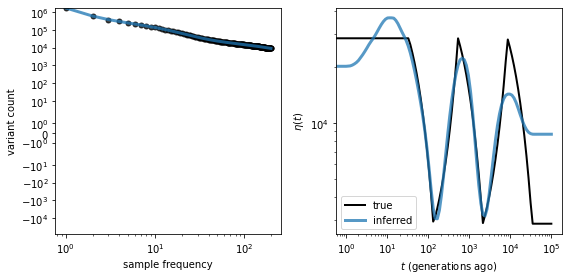

In [10]:
ksfs.clear_eta()
ksfs.clear_mu()

# define regularization parameters and convergence criteria
convergence = dict(tol=0, max_iter=2000)
regularization_eta = dict(alpha_tv=1e-1, alpha_spline=1e1, alpha_ridge=1e-10)

ksfs.infer_history(change_points, mu0, infer_mu=False,
                   **regularization_eta, **convergence)
plt.figure(figsize=(8, 4))
plt.subplot(121)
ksfs.plot_total(kwargs=dict(ls='', marker='o', ms=5, c='k', alpha=0.75),
                line_kwargs=dict(c='C0', alpha=0.75, lw=3),
                fill_kwargs=dict(color='C0', alpha=0.1))
plt.subplot(122)
eta_true.plot(c='k', lw=2, label='true')
ksfs.eta.plot(lw=3, alpha=0.75, label='inferred')
plt.legend()
plt.show()

Now infer $\mu(t)$

In [ ]:
ksfs.clear_mu()

# define regularization parameters and convergence criteria
regularization_mu = dict(hard=True, beta_rank=5e2, beta_tv=3e1, beta_spline=3e2, beta_ridge=1e-10)
convergence = dict(tol=1e-12, max_iter=10000)

ksfs.infer_history(change_points, mu0, infer_eta=False,
                   **regularization_mu, **convergence)

plt.figure(figsize=(9, 3))

plt.subplot(131)
ksfs.plot(range(2, cols), clr=True, kwargs=dict(alpha=0.1, ls='', marker='.', ms=5, mfc='none', c='C0', rasterized=True),
          line_kwargs=dict(alpha=0.1, lw=1, c='C0', rasterized=True))
ksfs.plot((0,), clr=True, kwargs=dict(alpha=0.75, ls='', marker='.', ms=10, mfc='none', c='C1'),
          line_kwargs=dict(alpha=0.75, lw=2, c='C1'))
ksfs.plot((1,), clr=True, kwargs=dict(alpha=0.75, ls='', marker='.', ms=10, mfc='none', c='C2'),
          line_kwargs=dict(alpha=0.75, lw=2, c='C2'))

plt.subplot(132)
mu_true.plot(range(2, cols), alpha=0.1, lw=2, c='C0', clr=True, rasterized=True)
ksfs.mu.plot(range(2, cols), alpha=0.1, lw=3, ls='--', c='C0', clr=True, rasterized=True)
mu_true.plot((0,), alpha=0.75, lw=2, c='C1', clr=True)
ksfs.mu.plot((0,), alpha=0.75, lw=3, ls='--', c='C1', clr=True)
mu_true.plot((1,), alpha=0.75, lw=2, c='C2', clr=True)
ksfs.mu.plot((1,), alpha=0.75, lw=3, ls='--', c='C2', clr=True)

plt.subplot(133)
σ = np.linalg.svd(cmp.ilr(ksfs.mu.Z), compute_uv=False)
x = np.arange(1, len(σ) + 1)
plt.scatter(x, σ)
plt.plot(x, σ, 'ko', ms=5, mfc='none', mew=.1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('singular value rank')
plt.ylabel('singular value')
plt.tight_layout()
plt.show()

inferring μ(t) conditioned on η(t)
initial objective -5.203805e+07


In [ ]:
# set this to e.g. your Downloads folder path if you want plots saved to pdfs
plot_dir = None

In [ ]:
mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

fig, axes = plt.subplots(nrows=2, ncols=2, sharex='col', figsize=(5.9, 5.5), gridspec_kw={'height_ratios': [1, 3]})

plt.sca(axes[0, 0])
ksfs.plot_total(kwargs=dict(ls='', alpha=0.75, marker='o', ms=5, mfc='none', c='k', label=r'simulated SFS, $\mathbf x$'),
                line_kwargs=dict(c='r', ls=':', marker='.', ms=3, alpha=0.75, lw=1, label=r'reconstructed SFS, $\boldsymbol{\xi}$'),
                fill_kwargs=dict(alpha=0))
plt.xlabel(None)
plt.legend(fontsize=8)

plt.sca(axes[1, 0])
ksfs.plot(range(2, cols), clr=True, kwargs=dict(alpha=0.1, ls='', marker='o', ms=3, mfc='none', rasterized=True),
          line_kwargs=dict(ls=':', marker='.', ms=2, alpha=0.1, lw=1, rasterized=True))
ksfs.plot((0,), clr=True, kwargs=dict(ls='', marker='o', ms=5, mfc='none', c='C0'),
          line_kwargs=dict(ls=':', marker='.', ms=3, alpha=0.75, lw=2, c='C0'))
ksfs.plot((1,), clr=True, kwargs=dict(ls='', marker='o', ms=5, mfc='none', c='C1'),
          line_kwargs=dict(ls=':', marker='.', ms=3, alpha=0.75, lw=2, c='C1'))
plt.ylabel('variant count composition')
legend_elements = [Line2D([0], [0], ls='', marker='o', ms=5, mfc='none', color='k', label=r'simulated $k$-SFS, $\mathrm{clr}(\mathbf X)$'),
                   Line2D([0], [0], ls=':', marker='.', color='k', ms=3, lw=1, label=r'reconstructed $k$-SFS, $\mathrm{clr}(\boldsymbol\Xi)$')]
plt.legend(handles=legend_elements, loc='lower left', fontsize=8)

plt.sca(axes[0, 1])
eta_true.plot(c='k', alpha=1, lw=3, label='true')
ksfs.eta.plot(c='r', alpha=0.75, lw=2, label='inferred')
plt.legend(fontsize=8, loc='upper right')
plt.xlabel(None)

plt.sca(axes[1, 1])
mu_true.plot(range(2, cols), alpha=0.2, lw=2, rasterized=True, clr=True)
plt.gca().set_prop_cycle(None)
ksfs.mu.plot(range(2, cols), alpha=0.1, lw=1, ls='--', rasterized=True, clr=True)
mu_true.plot((0,), alpha=0.75, lw=3, c='C0', clr=True)
ksfs.mu.plot((0,), alpha=0.75, lw=2, c='C0', clr=True, ls='--')
mu_true.plot((1,), alpha=0.75, lw=3, c='C1', clr=True)
ksfs.mu.plot((1,), alpha=0.75, lw=2, c='C1', clr=True, ls='--')
plt.ylabel(r'$\mathrm{clr}(\boldsymbol{\mu}(t))$')
legend_elements = [Line2D([0], [0], color='k', lw=2, label='true'),
                   Line2D([0], [0], color='k', ls='--', lw=1, label='inferred')]
plt.legend(handles=legend_elements, loc='lower left', fontsize=8)
plt.xlim([1e1, 5e4])

plt.tight_layout()
if plot_dir:
    plt.savefig(f'{plot_dir}/sim.pdf', dpi=300)
plt.show()